# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [3]:
import napari
from macrohet import dataio, tile
import btrack

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [6]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = dataio.read_harmony_metadata(metadata_fn)
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [9]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [13]:
row = 3
column = 5

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [14]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
#                              set_time = 66,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [30]:
%%time
images = images.compute().compute()

CPU times: user 3h 40min 46s, sys: 14min 5s, total: 3h 54min 52s
Wall time: 12min 24s


# Load tracks

In [32]:
with btrack.dataio.HDF5FileHandler(f"/mnt/DATA/macrohet/labels/full_localisation/upscale_{row,column}.h5", 'r') as hdf:
    tracks = hdf.tracks
    segmentation = hdf.segmentation
    objects = hdf.objects
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/04/13 01:09:55 pm] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/upscale_(3, 5).h5...
13-Apr-23 13:09:55 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/upscale_(3, 5).h5...
[INFO][2023/04/13 01:09:55 pm] Loading tracks/obj_type_1
13-Apr-23 13:09:55 - btrack.dataio - INFO     - Loading tracks/obj_type_1
[INFO][2023/04/13 01:09:55 pm] Loading LBEP/obj_type_1
13-Apr-23 13:09:55 - btrack.dataio - INFO     - Loading LBEP/obj_type_1
[INFO][2023/04/13 01:09:56 pm] Loading objects/obj_type_1 (31313, 5) (31313 filtered: None)
13-Apr-23 13:09:56 - btrack.dataio - INFO     - Loading objects/obj_type_1 (31313, 5) (31313 filtered: None)
[INFO][2023/04/13 01:10:07 pm] Loading segmentation (75, 6048, 6048)
13-Apr-23 13:10:07 - btrack.dataio - INFO     - Loading segmentation (75, 6048, 6048)
[INFO][2023/04/13 01:10:07 pm] Loading objects/obj_type_1 (31313, 5) (31313 filtered: None)
13-Apr-23 13:10:07 - btrack.dataio - INFO     - L

# Launch napari image viewer

In [31]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[100, 6000], [100, 2000]]
                 )
viewer.add_labels(segmentation, 
                  #scale=(10, 1, 1,), 
#                   color={1:'yellow'}
                 )
viewer.add_tracks(napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
#                     scale = (100,1,1)
                )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'napari_tracks' at 0x7faaad312940>

# Fixing duplicate localisation bug

When tracking on upscaled images, there appears to be multiple localisations for each cell.

In [35]:
objects[0].t

0

In [66]:
objects[0]

,ID,x,y,z,t,dummy,states,label,area,major_axis_length,mean_intensity-0,mean_intensity-1,minor_axis_length,orientation
0,0,361.416382,82.760368,0.0,0,False,7,5,21045.0,214.413834,1194.513794,344.165924,129.839615,0.75574


In [36]:
# isolate objects in first frame
objs_t0 = [o for o in objects if o.t == 0]

In [54]:
# isolate objects in second frame
objs_t1 = [o for o in objects if o.t == 1]

In [55]:
len(objs_t0), len(objs_t1)

(482, 491)

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

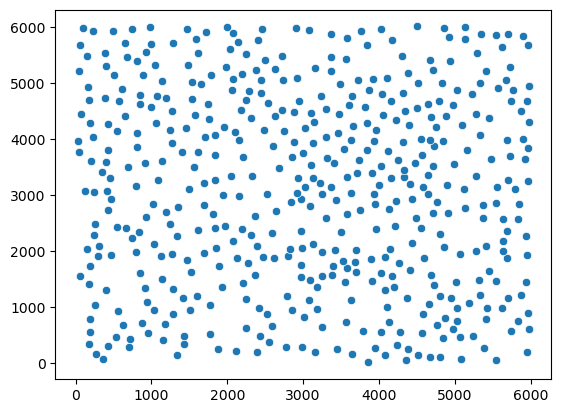

In [43]:
x_coords = [o.x for o in objs_t0]
y_coords = [o.y for o in objs_t0]
sns.scatterplot(x = x_coords, y = y_coords)

<AxesSubplot:>

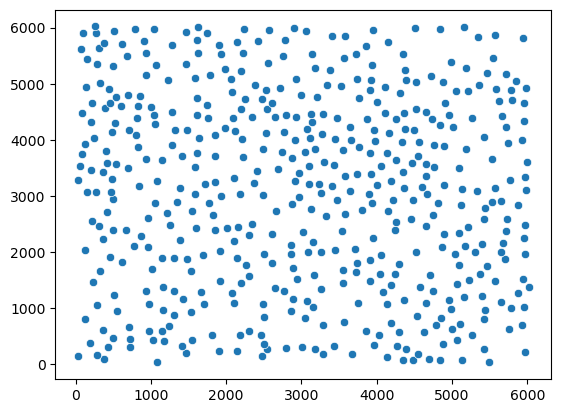

In [56]:
x_coords = [o.x for o in objs_t1]
y_coords = [o.y for o in objs_t1]
sns.scatterplot(x = x_coords, y = y_coords)

In [57]:
xy_coords = [[y, x] for x, y in zip(x_coords, y_coords)]

In [58]:
viewer.add_points(xy_coords, ndim=2)

<Points layer 'Points [1]' at 0x7fab1e4085e0>

happens at the second frame (t =1), does the tracker think the cells are dividing?

In [63]:
track_352 = [track for track in tracks if track.ID == 352][0]

In [64]:
track_352

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,minor_axis_length,orientation,area,major_axis_length,mean_intensity-0
0,352,0,1246.543945,2488.895020,0.000000,352,352,5,0,False,375.271912,205.807312,1.342122,82943.0,530.678467,1331.943604
1,352,0,545.977722,2432.095947,0.000000,352,352,5,0,False,371.126495,105.054680,1.044592,12403.0,151.087875,3039.468018
2,352,0,257.165314,2485.596680,0.000000,352,352,5,0,False,381.730988,168.419556,-1.251694,40935.0,343.183380,2464.495605
3,352,3,1829.978882,526.998413,-0.989887,352,352,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
4,352,0,5833.124512,2569.903076,0.000000,352,352,5,0,False,527.751404,166.894241,0.352546,33226.0,267.503113,1702.591187
5,352,5,1793.176636,555.813904,9.203656,352,352,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
6,352,0,5636.162598,2573.446045,0.000000,352,352,5,0,False,378.951324,228.625671,0.997570,65616.0,410.572693,2152.761719
7,352,7,1817.808472,541.045959,1.416201,352,352,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
8,352,0,933.739807,2609.950928,0.000000,352,352,5,0,False,374.938660,153.932327,-0.301992,37422.0,323.986023,2121.225586
9,352,0,5130.161621,2765.235107,0.000000,352,352,5,0,False,430.740387,237.120209,-0.561356,94283.0,549.959961,2459.670898


In [61]:
track_463 = [track for track in tracks if track.ID == 463][0]

In [62]:
track_463

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,minor_axis_length,orientation,area,major_axis_length,mean_intensity-0
0,463,1,937.581421,5157.688965,0.000000,463,463,5,0,False,393.750641,173.584747,1.042029,48065.0,366.222046,1671.662476
1,463,1,247.657028,2289.098145,0.000000,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,463,2,247.657028,2289.098145,0.000000,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
3,463,1,1981.854980,5271.165039,0.000000,463,463,5,0,False,354.846161,266.721039,0.160620,76747.0,381.243866,2246.653809
4,463,4,376.375641,2251.976807,0.045263,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
5,463,1,5182.459961,5276.767578,0.000000,463,463,5,0,False,378.238617,218.019180,0.020345,68762.0,433.842621,2224.533447
6,463,6,425.911743,2227.082031,-1.325690,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
7,463,7,468.839905,2209.047363,-2.651379,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
8,463,8,511.768066,2191.012695,-3.977068,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
9,463,9,554.696228,2172.978027,-5.302758,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
def track_and_show(objects, masks, config_fn, search_radius = 20, method = ["MOTION", "VISUAL"]):
    
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, 6048), (0, 6048))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks
    
    napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)
    
    viewer.add_tracks(napari_tracks, 
                      blending="translucent",
                      visible=True,)

In [86]:
track_and_show(objects, 
               segmentation, 
               '/home/dayn/analysis/btrack/models/cell_config.json', 
               5, 
               ["MOTION",]# "VISUAL"]
              )

OSError: Cannot load shared library /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so